In [66]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import random
from pydantic import BaseModel, ValidationError
from typing import List
import uuid 
import numpy as npp

## 1. Number of transactions per day

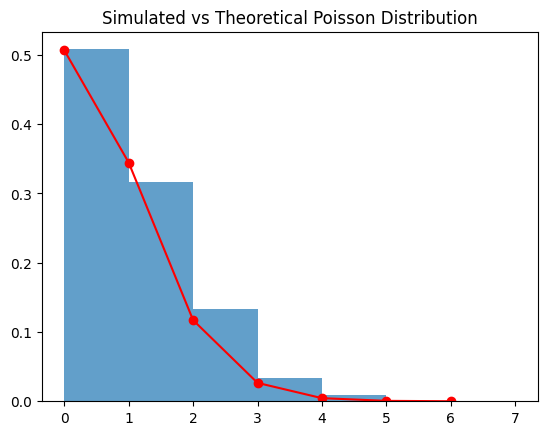

In [67]:
# 251 transactions per year = 0.68 transactions per day
daily_txn = np.random.poisson(0.68, size=1000)
plt.hist(daily_txn, bins=range(max(daily_txn)+2), density=True, alpha=0.7)
x = range(max(daily_txn)+1)
plt.plot(x, stats.poisson.pmf(x, 0.68), 'ro-')
plt.title('Simulated vs Theoretical Poisson Distribution')
plt.show()

## 2. Value of each transaction

In [68]:
def compute_sigma(mean:float, cv:float) -> float:
    """ 
    a formula to calculate sigma from mean and CV
    """
    variance = (mean * cv)**2
    sigma_sq = np.log(1 + variance/(mean**2))
    sigma = np.sqrt(sigma_sq)
    # get the value from numpy array
    return sigma.item()

def compute_sigma_v2(cv):
    """ 
    Calculate sigma given CV
    the CV alone doesn't fully specify the distribution. 
    You still need a measure of central tendency (like the mean) to "position" the distribution on the x-axis.
    """
    sigma = np.sqrt(np.log(1 + cv**2))
    return sigma

In [69]:
compute_sigma_v2(0.75)

np.float64(0.6680472308365776)

In [70]:
compute_sigma(mean=96.49, cv=0.75)

0.6680472308365776

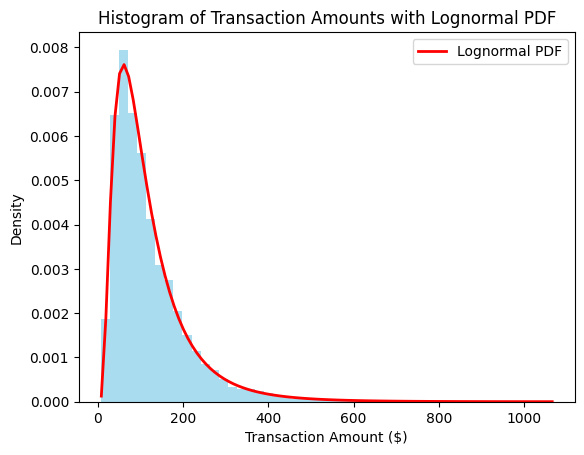

In [71]:
# Generate lognormal txn_value
mean = 96.49
sigma = 0.6873
size = 10000
txn_value = np.random.lognormal(mean=np.log(mean), sigma=sigma, size=size)

# Create histogram
plt.hist(txn_value, bins=50, density=True, alpha=0.7, color='skyblue')

# Calculate PDF
x = np.linspace(txn_value.min(), txn_value.max(), 100)
pdf = stats.lognorm.pdf(x, s=sigma, scale=np.exp(np.log(mean)))

# Plot PDF
plt.plot(x, pdf, 'r-', lw=2, label='Lognormal PDF')
plt.xlabel('Transaction Amount ($)')
plt.ylabel('Density')
plt.title('Histogram of Transaction Amounts with Lognormal PDF')
plt.legend()
plt.show()

## 3. Consolidated Customer spending profile

In [72]:
# create a dictionary to contain profiles abvoe for the uniform distributions of mean and CV:
group_profiles = {
    'name': ['low', 'low-middle', 'middle', 'high-middle', 'high'],
    'txn_mean_low': [5, 20, 40, 60, 80],
    'txn_mean_high': [20, 40, 60, 80, 100],
    'txn_cv_low': [0.3, 0.4, 0.5, 0.6, 0.7],
    'txn_cv_high': [0.4, 0.5, 0.6, 0.7, 0.8],
    'txn_lambda': [0.25, 0.5, 1, 1.5, 2] # to simplify, we assume middle income person has average 1 txn per day
}

class GroupProfiles(BaseModel):
    name: List[str]
    txn_mean_low: List[float]
    txn_mean_high: List[float]
    txn_cv_low: List[float]
    txn_cv_high: List[float]
    txn_lambda: List[float]

# Validate the input dictionary using assert
try:
    validated_profiles = GroupProfiles(**group_profiles)
    assert validated_profiles
    print("Validation successful!")
except ValidationError as e:
    assert False, f"Validation failed: {e}"

# visualize in a table
df = pd.DataFrame(group_profiles)
df


Validation successful!


,name,txn_mean_low,txn_mean_high,txn_cv_low,txn_cv_high,txn_lambda
0,low,5,20,0.3,0.4,0.25
1,low-middle,20,40,0.4,0.5,0.50
2,middle,40,60,0.5,0.6,1.00
3,high-middle,60,80,0.6,0.7,1.50
4,high,80,100,0.7,0.8,2.00


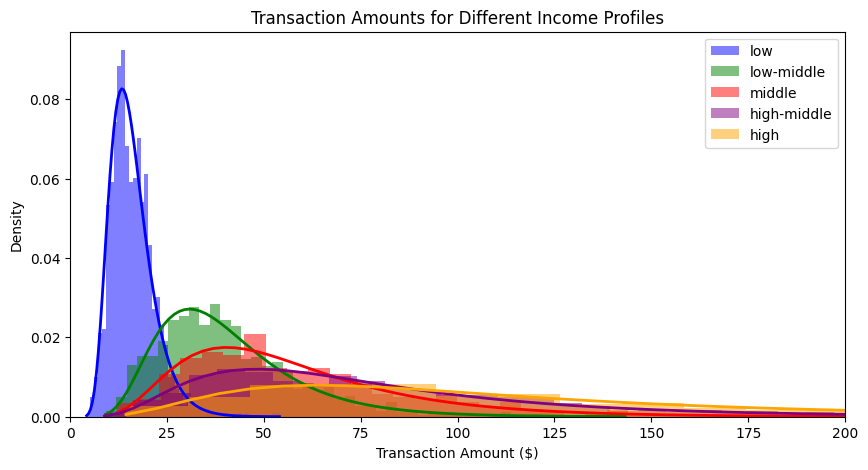

In [73]:
# Illustrating the spending habit of the groups above by generate 1000 transactions for a customer of each profile

# Set seed for reproducibility
random.seed(99)
np.random.seed(99)

colors = ['blue', 'green', 'red', 'purple', 'orange']
plt.figure(figsize=(10, 5))
for i, profile in enumerate(df["name"]):
    row = df[df["name"] == profile].iloc[0]
    profile_dict = row.to_dict()

    mean_amount = np.random.uniform(profile_dict["txn_mean_low"], profile_dict["txn_mean_high"])
    cv = np.random.uniform(profile_dict["txn_cv_low"], profile_dict["txn_cv_high"])
    sigma = compute_sigma(mean_amount, cv)
    txn_value = np.random.lognormal(mean=np.log(mean_amount), sigma=sigma, size=1000)
    
    # Plot histogram
    plt.hist(txn_value, bins=50, density=True, alpha=0.5, label=profile, color=colors[i])
    
    # Calculate and plot PDF
    x = np.linspace(txn_value.min(), txn_value.max(), 100)
    pdf = stats.lognorm.pdf(x, s=sigma, scale=np.exp(np.log(mean_amount)))
    plt.plot(x, pdf, color=colors[i], lw=2)

plt.xlim(0, 200)
plt.title('Transaction Amounts for Different Income Profiles')
plt.xlabel('Transaction Amount ($)')
plt.ylabel('Density')
plt.legend()
plt.show()

## 4. Generator and Customer Classes

In [74]:
# find current time
from datetime import datetime
datetime.now()

# convert to string
datetime.now().strftime('%Y-%m-%d %H:%M:%S')

'2025-02-24 00:22:03'

In [75]:
from datetime import datetime, timedelta
from pydantic import BaseModel
from typing import List
from datetime import datetime


class GroupProfiles(BaseModel):
    name: List[str]
    txn_mean_low: List[float]
    txn_mean_high: List[float]
    txn_cv_low: List[float]
    txn_cv_high: List[float]
    txn_lambda: List[float]


class Customer:
    def __init__(self, profile: dict):
        self.profile = profile
        # self.customer_txns = []
        self._date_format = "%Y-%m-%d"
        self._timestamp_format = "%Y-%m-%d %H:%M:%S"
        self._big_ticket_proba = 0.005
        self._big_ticket_multiplier = 10 # Adjust the multiplier as needed

    def generate_txn_value(self):
        """
        Generate a single transaction value for a customer based on their profile
        In addition, there is a fixed probability (0.5%) of a big-ticket item
        """

        if np.random.rand() < self._big_ticket_proba: # rand() generates from uniform [0,1), thus there is 0.5% chance that the value is less than 0.005
            
            # Generate a big-ticket item
            big_ticket_mean = (
                self.profile["txn_mean"] * self._big_ticket_multiplier
            )  
            big_ticket_sigma = self.profile["txn_sigma"]
            txn_value = round(
                np.random.lognormal(
                    mean=np.log(big_ticket_mean),
                    sigma=big_ticket_sigma,
                ),
                2,
            )
        else:
            # Generate a regular transaction
            txn_value = round(
                np.random.lognormal(
                    mean=np.log(self.profile["txn_mean"]),
                    sigma=self.profile["txn_sigma"],
                ),
                2,
            )
        return txn_value
    
    def generate_current_txn(self):
        """ 
        Generate a single transaction for a customer based on their profile with the current timestamp
        """
        txn_value = self.generate_txn_value()
        txn_timestamp = datetime.now().strftime(self._timestamp_format)
        return {"txn_timestamp": txn_timestamp, "txn_value": txn_value}

    def generate_batch_txns(self, start_date: str = "2024-01-01", num_days: int = 30) -> List[dict]:
        """
        Gererate a list of customer transactions for a given number of days

        Parameters:
        -----------
        start_date: str
            The starting date of the transactions in the format 'YYYY-MM-DD'
        num_days: int
            The number of days for which to generate transactions

        Returns:
        --------
        None
            adds the generated transactions to the customer_txns attribute
        """
        batch_txns = []
        for day in range(num_days):
            num_txn = np.random.poisson(self.profile["txn_lambda"])
            if num_txn > 0:
                for _ in range(num_txn):
                    # Time of transaction: revolves around noontime, with std 20000 seconds. This is meant to simulate the fact that most transactions should occur during the day (e.g., grocery, gas, other shopping...)
                    time_txn = int(np.random.normal(86400 / 2, 20000))

                    if (time_txn > 0) and (time_txn < 86400):
                        txn_value = self.generate_txn_value()

                        txn_timestamp = datetime.fromtimestamp(
                            time_txn, tz=None
                        ) + timedelta(days=day)

                        txn_timestamp = datetime.strptime(
                            start_date, self._date_format
                        ) + timedelta(seconds=time_txn, days=day)

                        batch_txns.append(
                            {
                                # "day": day,
                                # "time_seconds": time_txn + day * 86400,
                                "txn_timestamp": txn_timestamp.strftime(
                                    self._timestamp_format
                                ),
                                "txn_value": txn_value,
                            }
                        )
        return batch_txns


class CustomerGenerator:
    def __init__(self, group_profiles: dict):
        """
        Initialize the CustomerGenerator with a dictionary of group profiles.
        
        Parameters:
        -----------
        group_profiles: dict
            A dictionary containing the group profiles for generating customer transactions.
            The dictionary must have the following structure where the key names and their value types are compulsory:
            {
                'name': ['low', 'low-middle', 'middle', 'high-middle', 'high'],
                'txn_mean_low': [5, 20, 40, 60, 80],
                'txn_mean_high': [20, 40, 60, 80, 100],
                'txn_cv_low': [0.3, 0.4, 0.5, 0.6, 0.7],
                'txn_cv_high': [0.4, 0.5, 0.6, 0.7, 0.8],
                'txn_lambda': [0.25, 0.5, 1, 1.5, 2]
            }

        """
        # validate the group_profiles
        try:
            GroupProfiles(**group_profiles)
        except ValidationError as e:
            raise ValueError(f"Invalid group_profiles data: {e}")
        
        self.group_profiles = self._convert_col_to_row_oriented_profile(
            group_profiles, "name"
        )

    def generate_customer_from_profile(self, profile_name: str):
        """ 
        Generate a customer object with a specific profile, modelled from the chosen profile name
        """
        assert profile_name in self.group_profiles.keys(), "Profile name not found"
        profile = self.group_profiles[profile_name]
        txn_mean = round(np.random.uniform(profile["txn_mean_low"], profile["txn_mean_high"]), 2)
        cv = round(np.random.uniform(profile["txn_cv_low"], profile["txn_cv_high"]),2)
        txn_sigma = round(self._compute_sigma(txn_mean, cv), 2)
        txn_lambda = profile["txn_lambda"]
        customer_profile = {
            "txn_mean": txn_mean,
            "txn_sigma": txn_sigma,
            "txn_lambda": txn_lambda,
        }
        return Customer(customer_profile)

    def _convert_col_to_row_oriented_profile(
        self, input_dict: dict, key_field: str
    ) -> dict:
        """
        Convert a column-oriented dictionary, which is more concise, to a row-oriented dictionary, which is easier to extract field-specific data from.

        Example:
        --------
        input_dict = {
            'key_field': ['A', 'B', 'C'],
            'field1': [1, 2, 3],
            'field2': [4, 5, 6]
        }
        output_dict = {
            'A': {'field1': 1, 'field2': 4},
            'B': {'field1': 2, 'field2': 5},
            'C': {'field1': 3, 'field2': 6}
        }
        """
        assert (
            key_field in input_dict
        ), f"Key field '{key_field}' not found in input dictionary"
        output_dict = {}
        key_values = input_dict[key_field]
        other_fields = {k: v for k, v in input_dict.items() if k != key_field}

        for i, key in enumerate(key_values):
            output_dict[key] = {
                field: values[i] for field, values in other_fields.items()
            }

        return output_dict
    
    def _compute_sigma(self, mean:float, cv:float) -> float:
        """ 
        Calculate sigma from mean and the coefficient of variation (CV)
        """
        variance = (mean * cv)**2
        sigma_sq = np.log(1 + variance/(mean**2))
        sigma = np.sqrt(sigma_sq)
        # get the value from numpy array
        return sigma.item()

{'txn_mean': 52.13, 'txn_sigma': 0.55, 'txn_lambda': 1}
Average total transaction value: $1935.04


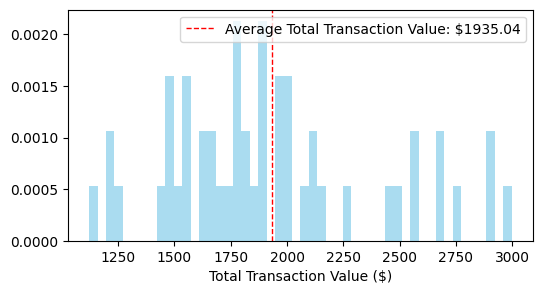

In [76]:
# Trials to finetune the profiles

customer_generator = CustomerGenerator(group_profiles)
customer = customer_generator.generate_customer_from_profile("middle")
print(customer.profile)

num_days = 30
num_trials = 50
total_txn_values = []
for trial in range(num_trials):
    
    customer_txns = customer.generate_batch_txns(num_days=num_days)
    total_txn_values.append(round(sum([txn["txn_value"] for txn in customer_txns]), 2))
# average total transaction value over all trials
avg_total_txn_value = round(np.mean(total_txn_values), 2)
print(f"Average total transaction value: ${avg_total_txn_value}")
# Plot histogram
plt.figure(figsize=(6, 3))
plt.hist(total_txn_values, bins=50, density=True, alpha=0.7, color="skyblue")
plt.xlabel("Total Transaction Value ($)")
# add average total transaction value to the plot
plt.axvline(
    avg_total_txn_value,
    color="red",
    linestyle="dashed",
    linewidth=1,
    label=f"Average Total Transaction Value: ${avg_total_txn_value}",
)
plt.legend()

In [77]:
customer_generator = CustomerGenerator(group_profiles)
customer = customer_generator.generate_customer_from_profile("middle")
print(customer.profile)

sample_txn = customer.generate_txn_value()
print(f"Sample transaction value: ${sample_txn}")

num_days=30

customer_txns = customer.generate_batch_txns(num_days=num_days, start_date="2024-01-01")
# customer_txns = customer.customer_txns

total_txn_value = round(sum([txn["txn_value"] for txn in customer_txns]), 2)
print(f"Total transaction value in {num_days} days: ${total_txn_value}")

customer_txns[:5]

{'txn_mean': 50.9, 'txn_sigma': 0.55, 'txn_lambda': 1}
Sample transaction value: $18.88
Total transaction value in 30 days: $1732.03


[{'txn_timestamp': '2024-01-02 08:53:16', 'txn_value': 66.17},
 {'txn_timestamp': '2024-01-04 11:46:07', 'txn_value': 37.92},
 {'txn_timestamp': '2024-01-06 11:14:01', 'txn_value': 50.61},
 {'txn_timestamp': '2024-01-06 11:45:21', 'txn_value': 57.09},
 {'txn_timestamp': '2024-01-07 07:44:56', 'txn_value': 21.85}]

## 5. Generate a sample dataset without fraud

1. Generate 100 customers with random profile
2. For each customer, generate 1 year of transactions


In [78]:
group_profiles

{'name': ['low', 'low-middle', 'middle', 'high-middle', 'high'],
 'txn_mean_low': [5, 20, 40, 60, 80],
 'txn_mean_high': [20, 40, 60, 80, 100],
 'txn_cv_low': [0.3, 0.4, 0.5, 0.6, 0.7],
 'txn_cv_high': [0.4, 0.5, 0.6, 0.7, 0.8],
 'txn_lambda': [0.25, 0.5, 1, 1.5, 2]}

In [79]:
# generate txns for each customer
start_date="2024-01-01"
num_days=365
txn_data = []
customer_data = []
num_customers = 1000

for i in range(1,num_customers+1):
    customer_id_num = 1000000 + i
    customer_id = f"c_{str(1000000 + i)[1:]}"
    customer_generator = CustomerGenerator(group_profiles)
    profile_name = random.choice(group_profiles["name"])
    customer = customer_generator.generate_customer_from_profile(profile_name)
    customer_txns = customer.generate_batch_txns(num_days=num_days, start_date=start_date)
    txn_data.append({"customer_id":customer_id, "customer_txns":customer_txns})
    customer_dict = customer.profile
    customer_dict["customer_id"] = customer_id
    customer_dict["profile_name"] = profile_name
    customer_data.append(customer_dict)

In [80]:
# convert the dataset to a dataframe, with each row representing a transaction, and customer_id as a column
df_txns = pd.DataFrame(
    [
        {"customer_id": row["customer_id"], **txn}
        for row in txn_data
        for txn in row["customer_txns"]
    ]
)
# add a unique transaction ID
df_txns["txn_id"] = df_txns.index.map(lambda x: f"t_{uuid.uuid4().hex[:10]}")
# rearrange by timestamp to simulate the real-world scenario
df_txns.sort_values(by="txn_timestamp", inplace=True)
df_txns.reset_index(drop=True, inplace=True)

df_customers = pd.DataFrame(customer_data)

In [81]:
df_txns

,customer_id,txn_timestamp,txn_value,txn_id
0,c_000083,2024-01-01 00:09:40,123.07,t_2729728189
1,c_000583,2024-01-01 00:10:44,12.38,t_26fab72b08
2,c_000554,2024-01-01 00:13:38,104.50,t_7a67319f58
3,c_000246,2024-01-01 00:40:01,68.76,t_6baec14996
4,c_000310,2024-01-01 00:55:32,78.24,t_aa70734e0d
...,...,...,...,...
360979,c_000710,2024-12-30 23:23:43,80.39,t_ce237b330d
360980,c_000126,2024-12-30 23:44:18,37.82,t_9c95be4404
360981,c_000763,2024-12-30 23:46:02,162.58,t_3f278592b5
360982,c_000918,2024-12-30 23:49:12,25.38,t_027c0c8941


In [ ]:
# convert txn_datetime to datetime object
df_txns["txn_timestamp"] = pd.to_datetime(df_txns["txn_timestamp"])

# add a date column
df_txns["txn_date"] = df_txns["txn_timestamp"].dt.date

In [106]:
# By default, all transactions are non-fraudulent
df_txns['txn_fraud']=0
df_txns['txn_fraud_scenario']=0

In [107]:
df_txns.iloc[0]

customer_id                      c_000083
txn_timestamp         2024-01-01 00:09:40
txn_value                          123.07
txn_id                       t_2729728189
txn_date                       2024-01-01
txn_fraud                               0
txn_fraud_scenario                      0
Name: 0, dtype: object

In [87]:
df_customers

,txn_mean,txn_sigma,txn_lambda,customer_id,profile_name
0,67.82,0.62,1.5,c_000001,high-middle
1,65.16,0.58,1.5,c_000002,high-middle
2,27.52,0.39,0.5,c_000003,low-middle
3,99.06,0.64,2.0,c_000004,high
4,26.72,0.45,0.5,c_000005,low-middle
...,...,...,...,...,...
995,37.73,0.39,0.5,c_000996,low-middle
996,87.23,0.68,2.0,c_000997,high
997,29.36,0.47,0.5,c_000998,low-middle
998,24.74,0.42,0.5,c_000999,low-middle


## 6. Fraud Scenarios

In [39]:
import numpy as np
from scipy.stats import norm

# Parameters of the underlying normal distribution
txn_mean = 100
mu = np.log(
    txn_mean
)  # The mu value in the log-normal distribution is the natural logarithm of the mean value of the original scale.
sigma = 0.7  # Standard deviation of the log

# GIVEN NUMBER OF SD, CALCULATE THE THRESHOLD VALUE AND % OF SAMPLES ABOVE THE THRESHOLD
# Threshold in terms of standard deviations from the mean
num_std_devs = 1.65

# Calculate the threshold value in the log-normal distribution
threshold = np.exp(mu + num_std_devs * sigma)

# Calculate the cumulative probability for the normal distribution
cdf_value = norm.cdf(mu + num_std_devs * sigma, loc=mu, scale=sigma)

# Calculate the percentage of samples above the threshold
percentage_above_threshold = (1 - cdf_value) * 100

print(f"Threshold value: {threshold}")
print(f"Percentage of samples above the threshold: {percentage_above_threshold:.2f}%")

# GIVEN THE PERCENTAGE OF SAMPLES, CALCULATE THE THRESHOLD VALUE AND NUMBER OF SD
# Percentage (e.g., 5% of samples above this value)
percentage = 5

# Calculate the quantile for the given percentage
quantile_value = norm.ppf(1 - percentage / 100, loc=mu, scale=sigma)

# Transform back to the original scale
threshold_value = np.exp(quantile_value)

# Calculate the number of Standard Deviations from the mean
num_std_devs = (quantile_value - mu) / sigma

print(f"Value above which there are {percentage}% of samples: {threshold_value}")
print(f"Number of standard deviations from the mean: {num_std_devs:.2f}")


def calculate_threshold(txn_mean: float, sigma: float, percentile: float):
    """
    Calculate the threshold value for a given percentile in a log-normal distribution.

    Parameters
    -----------
    txn_mean: float
        The transaction mean, in the original scale
    sigma: float
        The standard deviation of the log-normal distribution
    percentile: float
        The percentile value for which to calculate the threshold.
        E.g., 95 for 95th percentile, meaning 5% of samples are above this value.

    Returns
    --------
    float
        The threshold value for the given percentile
    """
    mu = np.log(txn_mean)
    quantile_value = norm.ppf(percentile / 100, loc=mu, scale=sigma)
    threshold_value = np.exp(quantile_value)
    return threshold_value.item()


calculate_threshold(txn_mean=100, sigma=0.7, percentile=99)

Threshold value: 317.4023417527599
Percentage of samples above the threshold: 4.95%
Value above which there are 5% of samples: 316.26096926215126
Number of standard deviations from the mean: 1.64


509.5936777167456

Monetary:
1. Case 1: Every day, ceiling(1% of customers active on that day) is drawn at random. In the next 14 days, a fixed portion (e.g., 25%) of their transactions are randomly selected, multiplied by 10, and marked as fraudulent.

2. Case 2: 

Recency, Frequency:
2. Small transactions in very quick successions. E.g., 5-10 transactions in 5 minutes.
3. Large transactions in quick successions. E.g., 2-3 transactions of uniform(1000, 10000) in 5 minutes.
4. A large transaction followed by a small transaction. E.g., uniform(1000, 10000) followed by uniform(100, 1000) in 5 minutes.


In [113]:
df_txns_with_fraud = df_txns.copy(deep=True)

In [119]:
# compromised_customers = customer_profiles_table.CUSTOMER_ID.sample(n=3, random_state=day).values

# compromised_transactions=transactions_df[(transactions_df.TX_TIME_DAYS>=day) & 
#                                             (transactions_df.TX_TIME_DAYS<day+14) & 
#                                             (transactions_df.CUSTOMER_ID.isin(compromised_customers))]
compromised_days = 14
compromised_txns_frac = 0.25
compromised_customers_frac = 0.01
compromised_multiplier = 5


day_start = min(df_txns_with_fraud["txn_date"])
day_end = day_start + timedelta(days=compromised_days)
compromised_customers_all = []

active_customers = df_txns_with_fraud[df_txns_with_fraud["txn_date"]==day_start]["customer_id"].unique()
active_customers_count = len(active_customers)
print(f"Number of active customers on {day_start}: {active_customers_count}")

# pick random % of active customers

compromised_customers = np.random.choice(active_customers, size=int(round(compromised_customers_frac * active_customers_count,0)), replace=False)
print(f"Number of compromised customers: {len(compromised_customers)}")

compromised_customers_txns = df_txns_with_fraud[(df_txns_with_fraud["txn_date"]>=day_start) & (df_txns_with_fraud["txn_date"]<day_end) & (df_txns_with_fraud["customer_id"].isin(compromised_customers))]


Number of active customers on 2024-01-01: 555
Number of compromised customers: 6


In [120]:
# compromised_customers_txns
nb_compromised_transactions=len(compromised_customers_txns)

random.seed(start_date)
index_frauds = random.sample(list(compromised_customers_txns.index.values),k=int(len(compromised_customers_txns)*compromised_txns_frac))

df_txns_with_fraud.loc[index_frauds, "txn_value"] = df_txns_with_fraud.loc[index_frauds, "txn_value"]*compromised_multiplier
df_txns_with_fraud.loc[index_frauds, "txn_fraud"] = 1
df_txns_with_fraud.loc[index_frauds, "txn_fraud_scenario"] = 1

In [121]:
df_txns_with_fraud[df_txns_with_fraud['txn_fraud']==1]

,customer_id,txn_timestamp,txn_value,txn_id,txn_date,txn_fraud,txn_fraud_scenario
110,c_000852,2024-01-01 05:30:55,13.13,t_87951df11e,2024-01-01,1,1
157,c_000845,2024-01-01 06:41:59,805.80,t_e11951cbfe,2024-01-01,1,1
610,c_000984,2024-01-01 13:52:08,335.05,t_741b6a76a3,2024-01-01,1,1
1019,c_000861,2024-01-02 03:44:27,62.11,t_c917e33b99,2024-01-02,1,1
1118,c_000215,2024-01-02 06:37:03,225.75,t_16b3e80e6c,2024-01-02,1,1
...,...,...,...,...,...,...,...
11497,c_000359,2024-01-12 13:59:38,60.87,t_685680e6d4,2024-01-12,1,1
11564,c_000984,2024-01-12 15:16:31,287.30,t_0c58239efc,2024-01-12,1,1
12010,c_000616,2024-01-13 07:25:05,207.20,t_ac24e65d9d,2024-01-13,1,1
12654,c_000616,2024-01-13 16:51:45,412.00,t_e97e4951a6,2024-01-13,1,1


In [123]:
df_txns[df_txns['txn_id'].isin(df_txns_with_fraud[df_txns_with_fraud['txn_fraud']==1]['txn_id'])]

,customer_id,txn_timestamp,txn_value,txn_id,txn_date,txn_fraud,txn_fraud_scenario
110,c_000852,2024-01-01 05:30:55,13.13,t_87951df11e,2024-01-01,0,0
157,c_000845,2024-01-01 06:41:59,161.16,t_e11951cbfe,2024-01-01,0,0
610,c_000984,2024-01-01 13:52:08,67.01,t_741b6a76a3,2024-01-01,0,0
1019,c_000861,2024-01-02 03:44:27,62.11,t_c917e33b99,2024-01-02,0,0
1118,c_000215,2024-01-02 06:37:03,45.15,t_16b3e80e6c,2024-01-02,0,0
...,...,...,...,...,...,...,...
11497,c_000359,2024-01-12 13:59:38,60.87,t_685680e6d4,2024-01-12,0,0
11564,c_000984,2024-01-12 15:16:31,57.46,t_0c58239efc,2024-01-12,0,0
12010,c_000616,2024-01-13 07:25:05,41.44,t_ac24e65d9d,2024-01-13,0,0
12654,c_000616,2024-01-13 16:51:45,82.40,t_e97e4951a6,2024-01-13,0,0
